步骤1: 数据准备与预处理
数据准备完成: 114个样本, 24个变量
已保存: results/问题2/数据概览分析.png


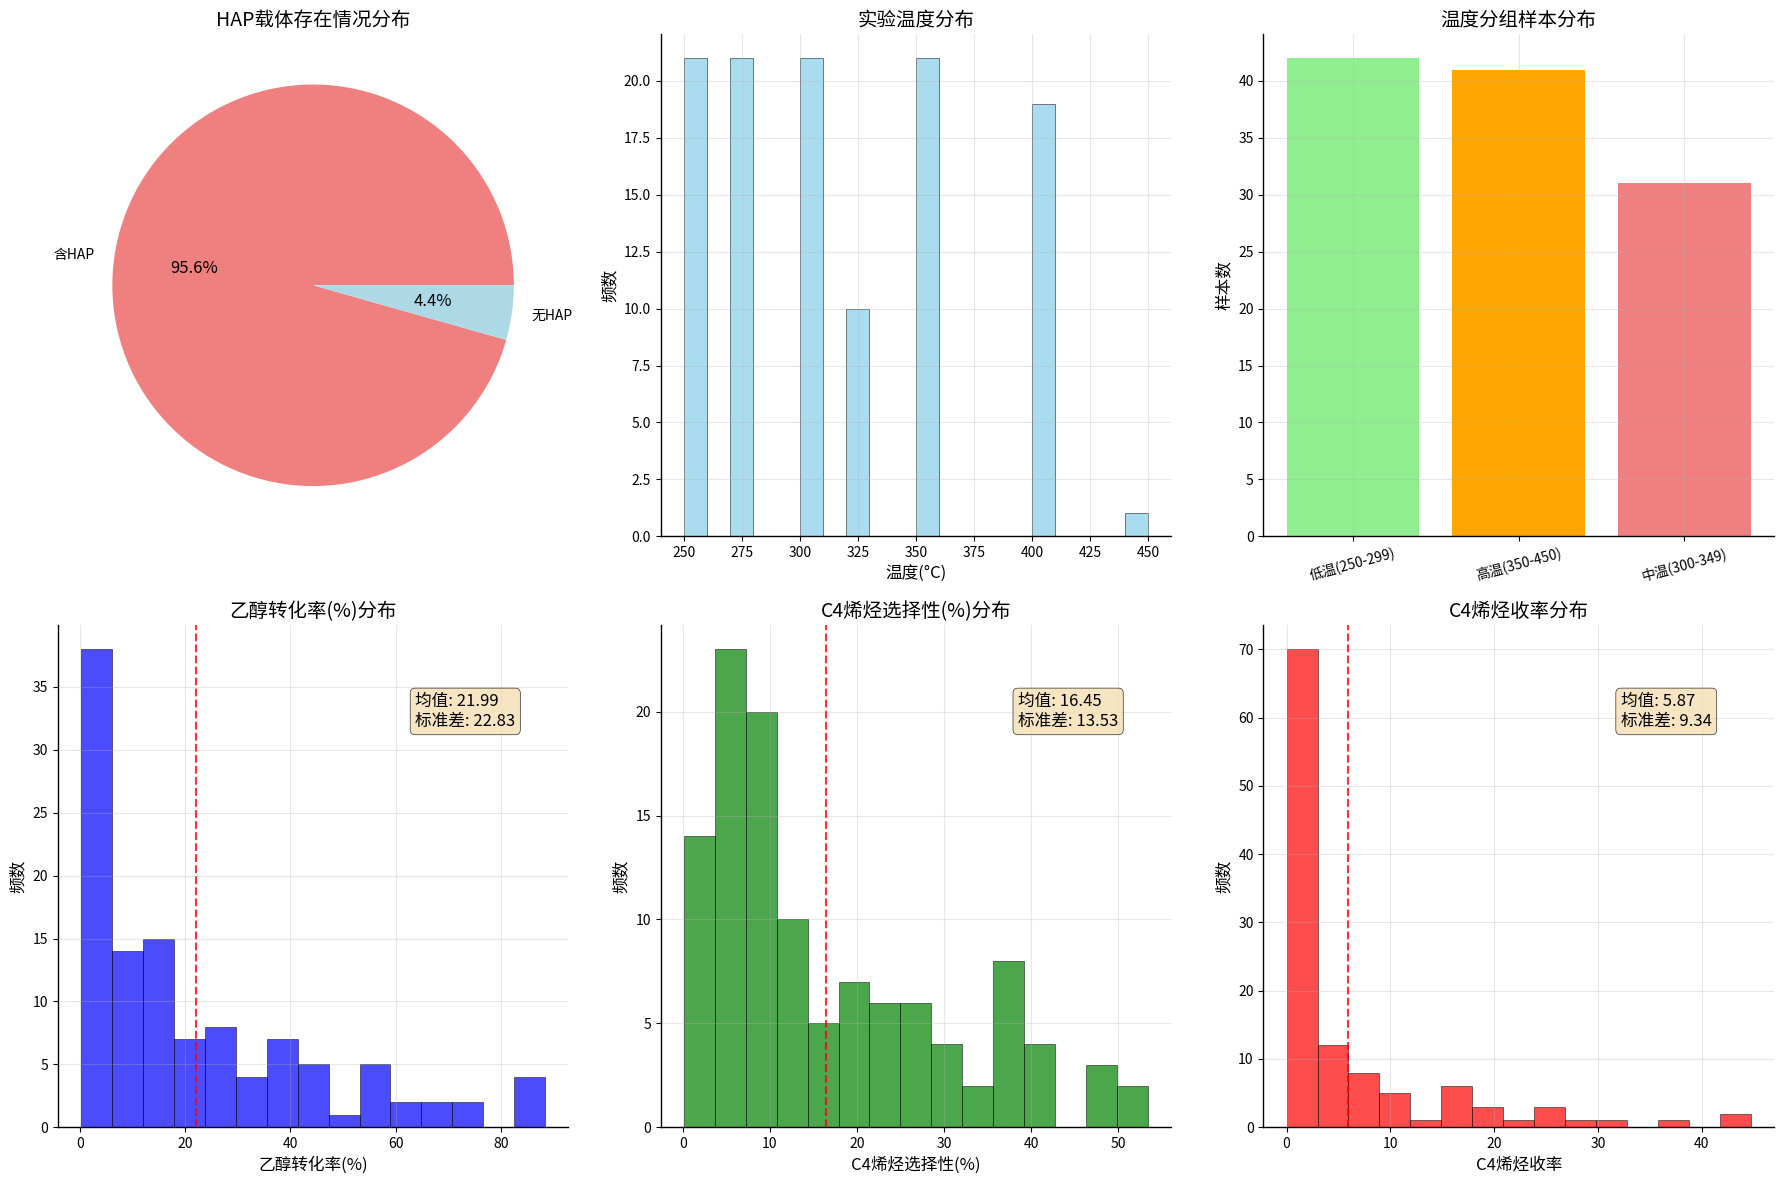

已保存: results/问题2/分组分析结果.png


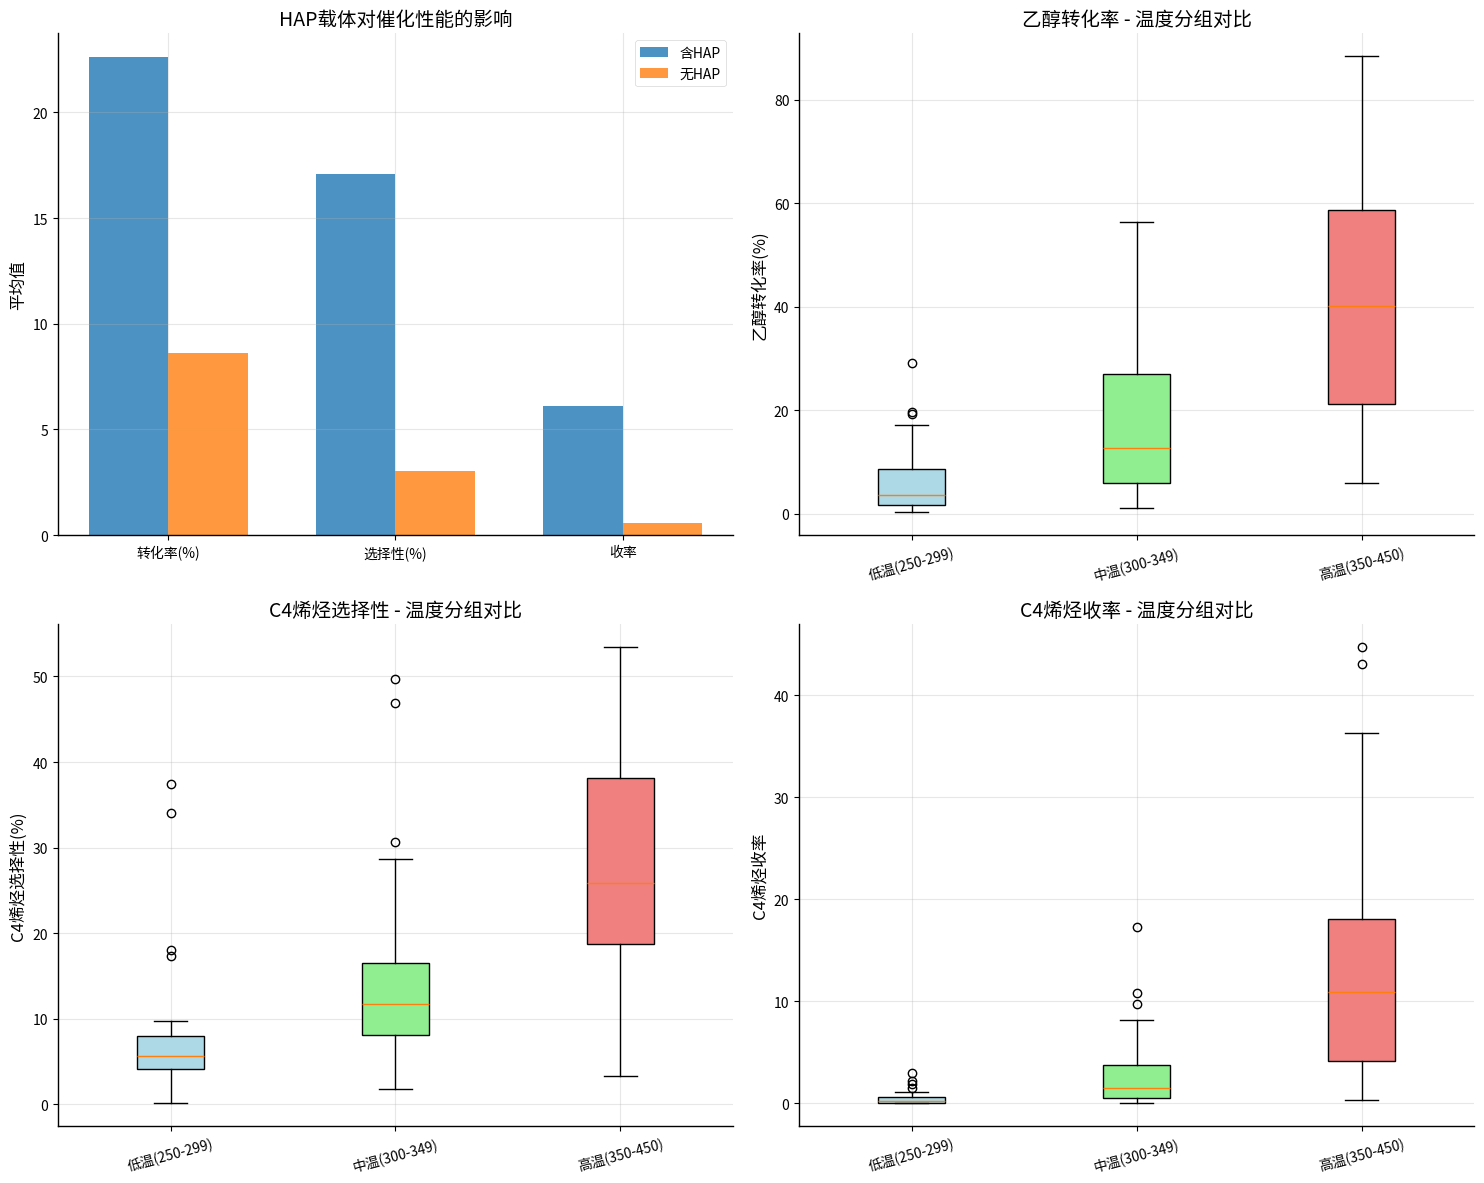


步骤2: 相关性分析
基于109个含HAP样本的相关性分析:

乙醇转化率(%)主要影响因子:
  温度: 0.778 (强正相关)
  HAP_mass: 0.392 (中等正相关)
  总催化剂质量: 0.390 (中等正相关)

C4烯烃选择性(%)主要影响因子:
  温度: 0.724 (强正相关)
  Co_SiO2_mass: 0.361 (中等正相关)
  总催化剂质量: 0.356 (中等正相关)

C4烯烃收率主要影响因子:
  温度: 0.744 (强正相关)
  总催化剂质量: 0.345 (中等正相关)
  Co_SiO2_mass: 0.344 (中等正相关)
已保存: results/问题2/相关性分析结果.png


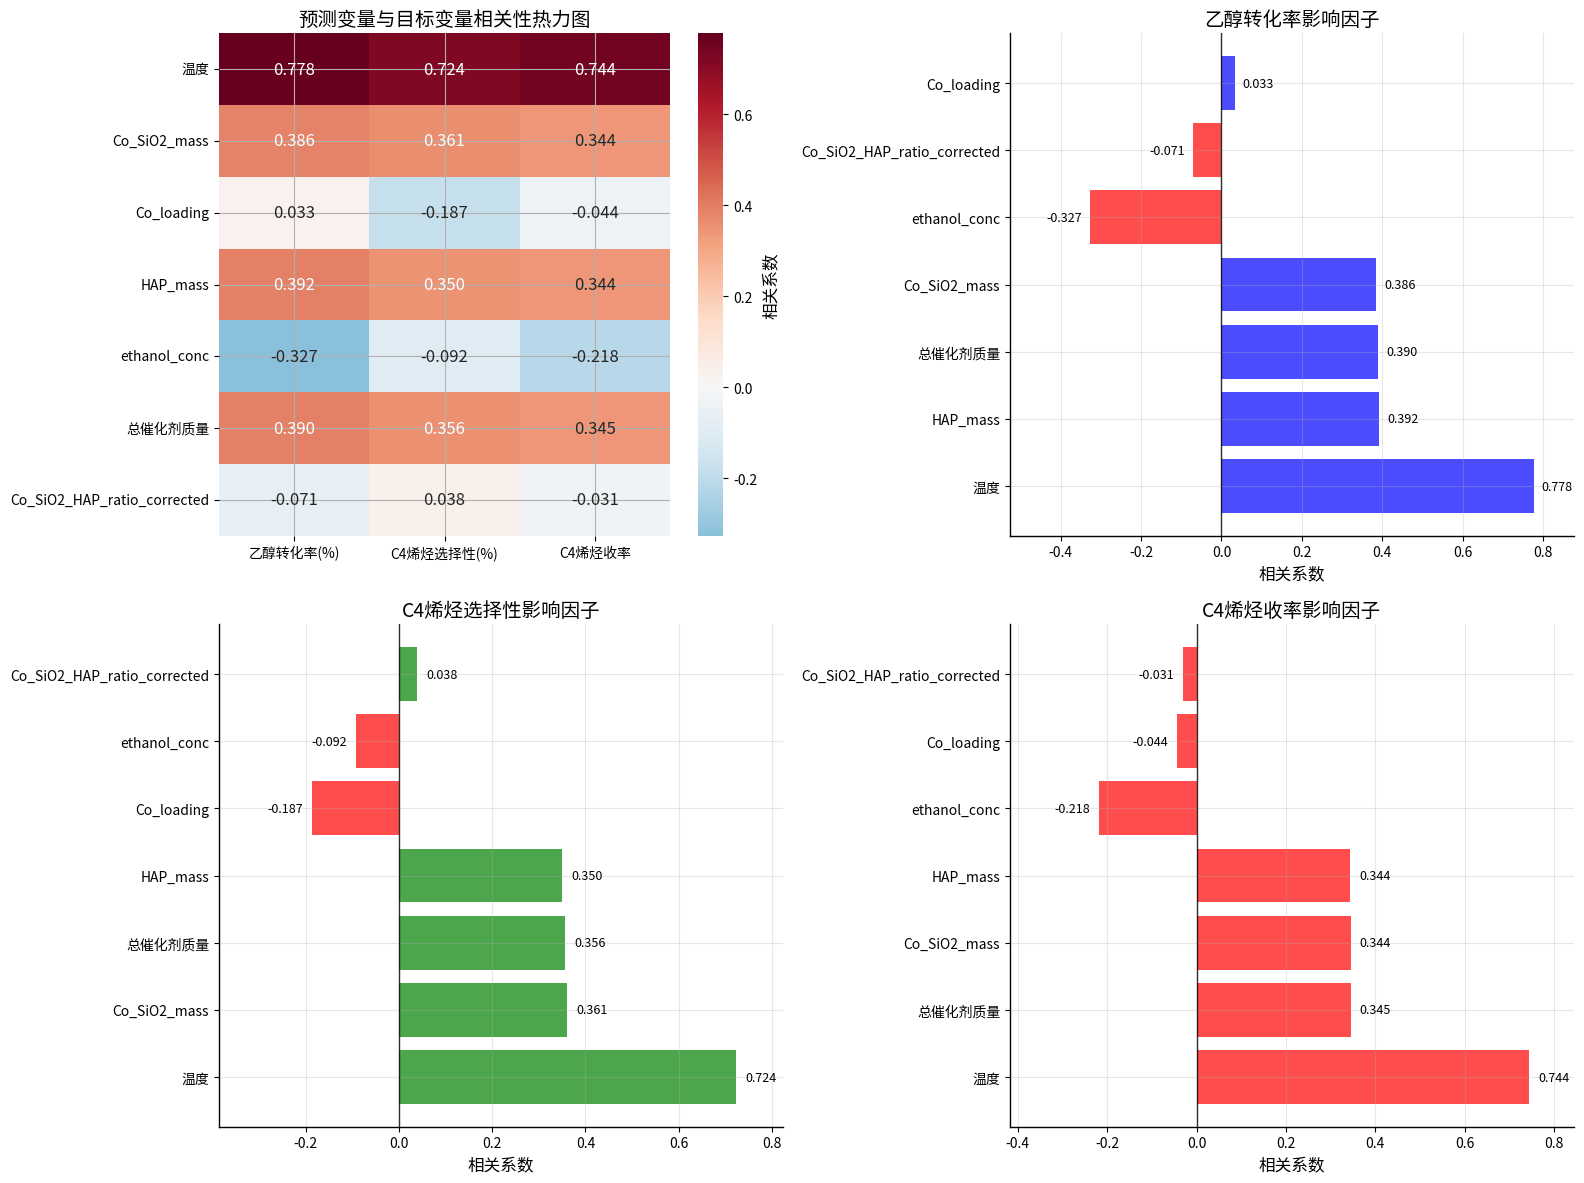


步骤3: 多元回归分析

乙醇转化率(%)回归模型:
  测试集R²: 0.7283
  5折交叉验证R²: 0.6588 ± 0.0976
  主要影响因子:
    温度: 18.0462 (正向)
    总催化剂质量: 8.5548 (正向)
    ethanol_conc: -4.1136 (负向)

C4烯烃选择性(%)回归模型:
  测试集R²: 0.6604
  5折交叉验证R²: 0.4844 ± 0.2235
  主要影响因子:
    温度: 9.8568 (正向)
    总催化剂质量: 6.0506 (正向)
    Co_loading: -3.7868 (负向)

C4烯烃收率回归模型:
  测试集R²: 0.4414
  5折交叉验证R²: 0.2066 ± 0.5830
  主要影响因子:
    温度: 7.3785 (正向)
    总催化剂质量: 3.5028 (正向)
    Co_loading: -0.9736 (负向)
已保存: results/问题2/回归分析结果.png


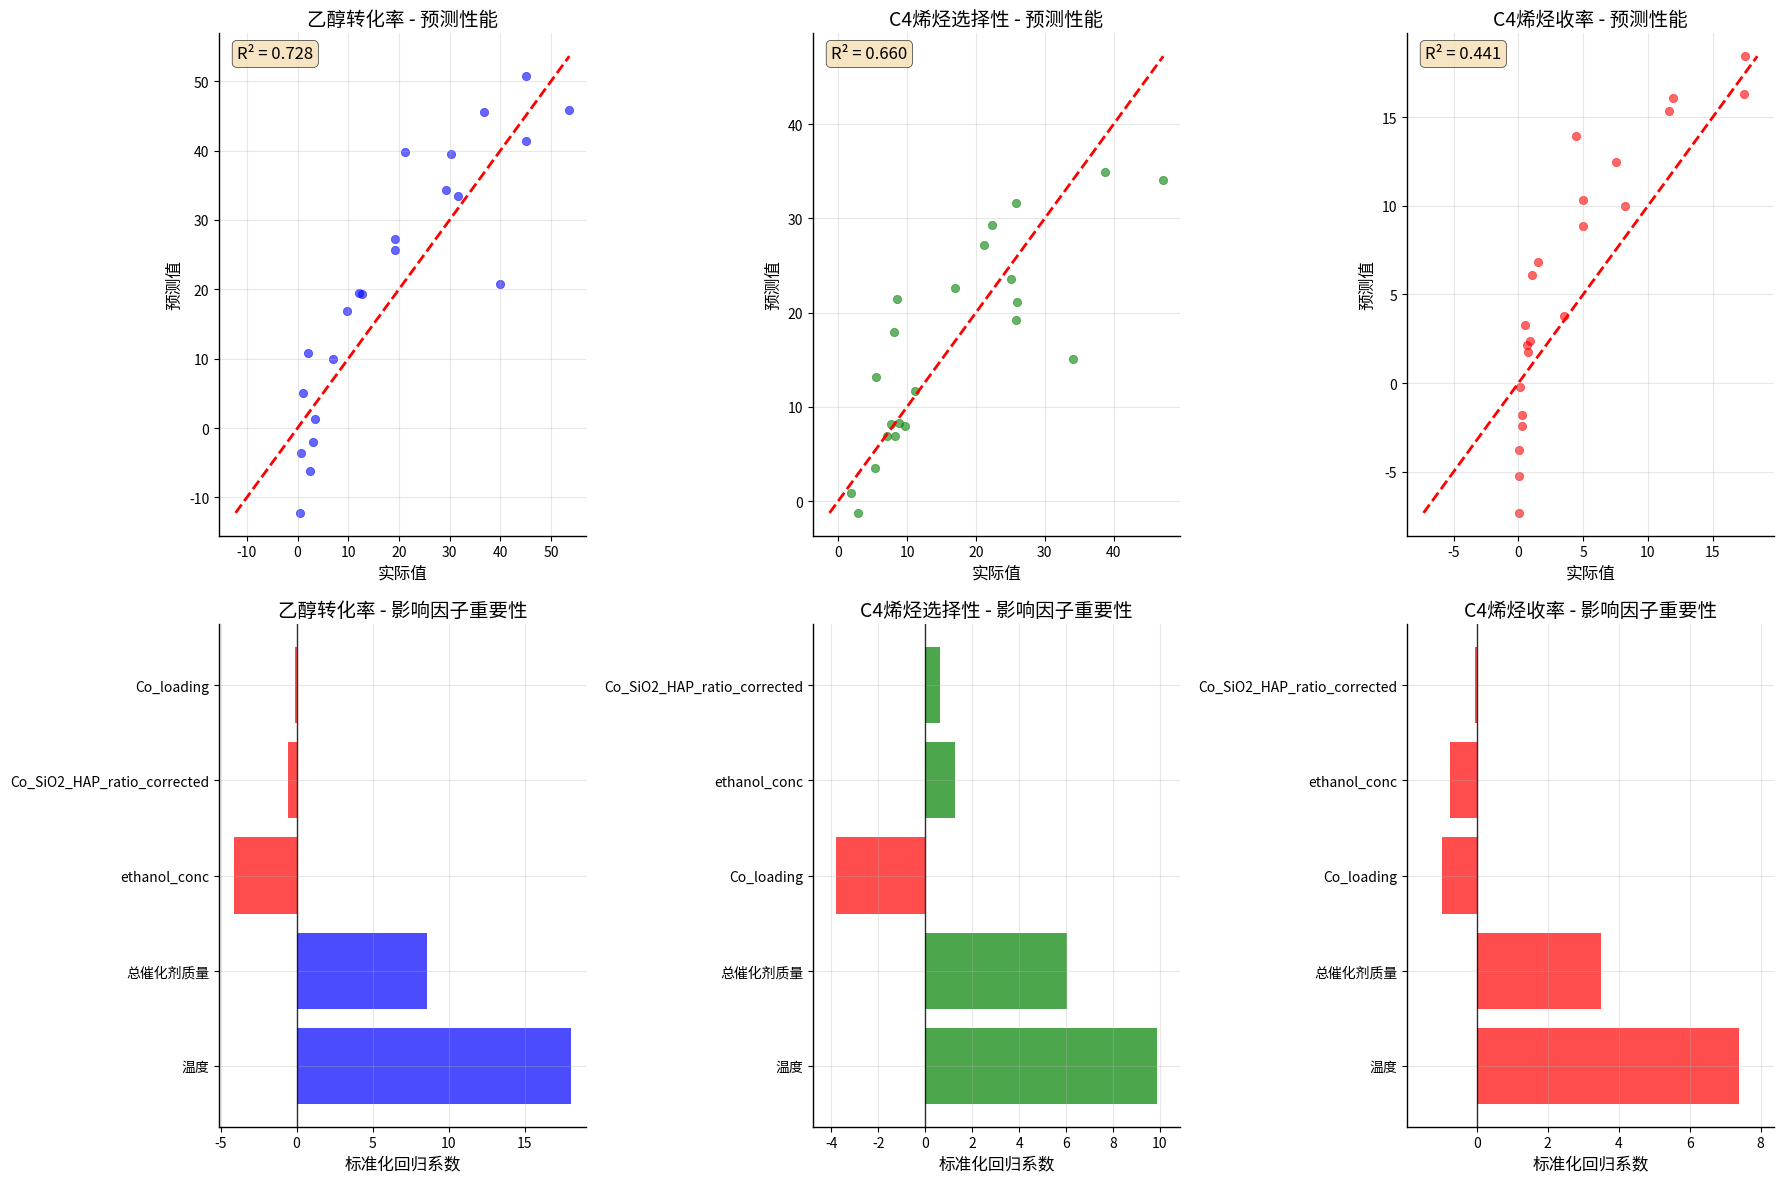


步骤4: 方差分析
单因素方差分析结果:

乙醇转化率(%):
  温度: F=49.42, p=0.0000 (显著), η²=0.483
  Co负载量: F=3.16, p=0.0464 (显著), η²=0.056

C4烯烃选择性(%):
  温度: F=40.81, p=0.0000 (显著), η²=0.435
  Co负载量: F=0.60, p=0.5486 (不显著), η²=0.011

C4烯烃收率:
  温度: F=36.72, p=0.0000 (显著), η²=0.409
  Co负载量: F=0.94, p=0.3934 (不显著), η²=0.017
已保存: results/问题2/方差分析结果.png


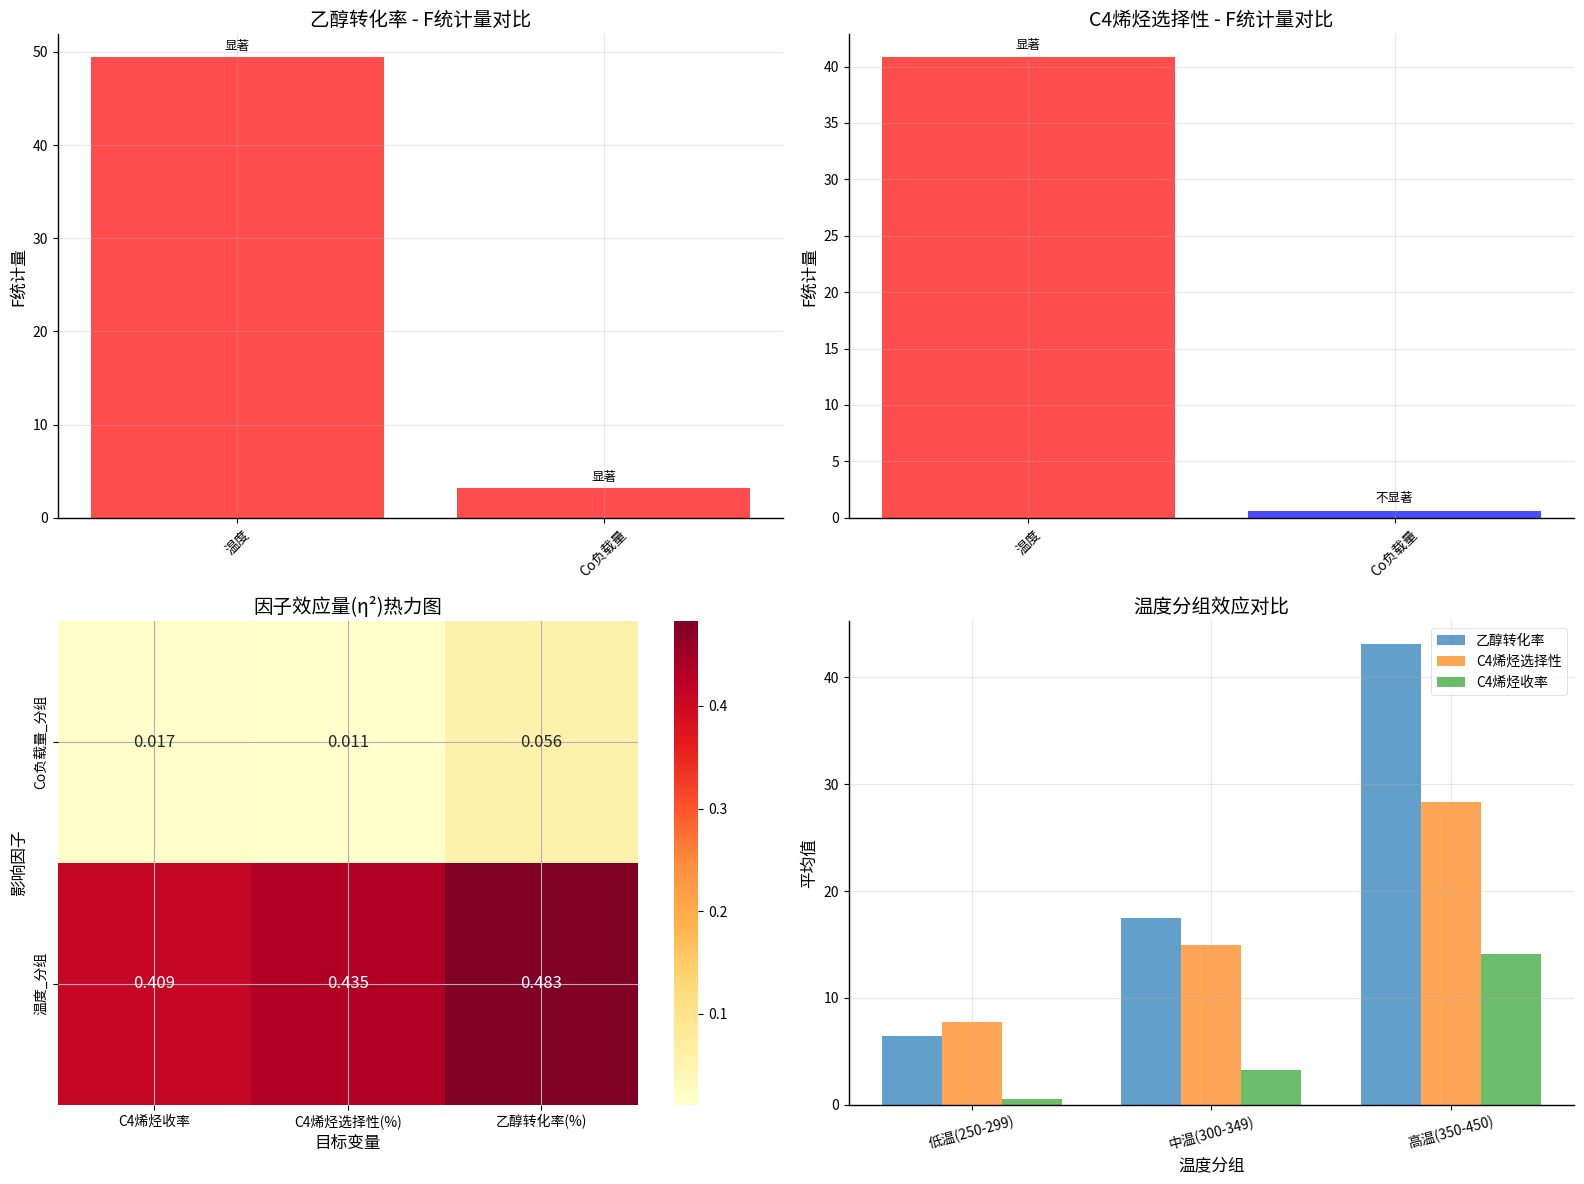


保存关键结果:
已保存: results/问题2/回归模型性能对比.csv
已保存: results/问题2/方差分析结果汇总.csv
已保存: results/问题2/乙醇转化率_回归系数.csv
已保存: results/问题2/C4烯烃选择性_回归系数.csv
已保存: results/问题2/C4烯烃收率_回归系数.csv

问题2分析完成，共生成8个结果文件


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

# 设置随机种子和输出格式
np.random.seed(42)
plt.rcParams['axes.unicode_minus'] = False

# 创建结果文件夹
import os
PROBLEM_NUM = 2
os.makedirs(f'results/问题{PROBLEM_NUM}', exist_ok=True)

def save_result(data, description, file_format='csv'):
    """保存重要结果到文件"""
    if file_format == 'csv':
        filename = f"results/问题{PROBLEM_NUM}/{description}.csv"
        data.to_csv(filename, encoding='utf-8-sig', index=False)
    elif file_format == 'excel':
        filename = f"results/问题{PROBLEM_NUM}/{description}.xlsx"
        data.to_excel(filename, index=False, engine='openpyxl')
    print(f"已保存: {filename}")
    return filename

def save_plot(description, dpi=300, format='png'):
    """保存图表到文件"""
    filename = f"results/问题{PROBLEM_NUM}/{description}.{format}"
    plt.savefig(filename, dpi=dpi, bbox_inches='tight')
    print(f"已保存: {filename}")
    return filename

def load_data(filename, encoding='utf-8-sig'):
    """标准化数据读取"""
    filepath = f"data/{filename}"
    if filename.endswith('.csv'):
        return pd.read_csv(filepath, encoding=encoding)
    elif filename.endswith('.xlsx'):
        return pd.read_excel(filepath, engine='openpyxl')
    else:
        raise ValueError(f"不支持的文件格式: {filename}")

# 1. 数据准备与预处理
def prepare_data():
    """数据准备和特征工程"""
    raw_data = load_data("附件1.csv")
    data = raw_data.copy()
    
    # 计算C4烯烃收率
    data['C4烯烃收率'] = data['乙醇转化率(%)'] * data['C4烯烃选择性(%)'] / 100
    
    # 创建HAP存在标志
    data['含HAP'] = data['HAP_mass'] > 0
    
    # 修正Co_SiO2_HAP_ratio计算
    data['Co_SiO2_HAP_ratio_corrected'] = np.where(
        data['HAP_mass'] > 0,
        data['Co_SiO2_mass'] / data['HAP_mass'],
        -1
    )
    
    # 创建分类变量用于方差分析
    data['温度_分组'] = pd.cut(data['温度'], 
                          bins=[249, 299, 349, 451], 
                          labels=['低温(250-299)', '中温(300-349)', '高温(350-450)'])
    
    data['Co负载量_分组'] = pd.cut(data['Co_loading'], 
                             bins=[0.4, 0.9, 1.5, 5.1], 
                             labels=['低负载(0.5-1.0)', '中负载(1.0-1.5)', '高负载(2.0-5.0)'])
    
    data['乙醇浓度_分组'] = pd.cut(data['ethanol_conc'], 
                            bins=[0.29, 1.0, 1.7, 2.11], 
                            labels=['低浓度(0.3-1.0)', '中浓度(1.0-1.7)', '高浓度(1.7-2.1)'])
    
    q25, q75 = data['总催化剂质量'].quantile([0.25, 0.75])
    data['催化剂质量_分组'] = pd.cut(data['总催化剂质量'], 
                             bins=[19, q25, q75, 401], 
                             labels=['少量', '中量', '大量'])
    
    print(f"数据准备完成: {len(data)}个样本, {len(data.columns)}个变量")
    return data

def visualize_data_overview(data):
    """数据概览可视化"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # HAP存在情况分布
    ax1 = axes[0, 0]
    hap_counts = data['含HAP'].value_counts()
    colors = ['lightcoral', 'lightblue']
    wedges, texts, autotexts = ax1.pie(hap_counts.values, labels=['含HAP', '无HAP'], 
                                      autopct='%1.1f%%', colors=colors)
    ax1.set_title('HAP载体存在情况分布')
    
    # 温度分布
    ax2 = axes[0, 1]
    ax2.hist(data['温度'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    ax2.set_xlabel('温度(°C)')
    ax2.set_ylabel('频数')
    ax2.set_title('实验温度分布')
    ax2.grid(True, alpha=0.3)
    
    # 催化剂组合类型分布
    ax3 = axes[0, 2]
    group_counts = data['温度_分组'].value_counts()
    ax3.bar(range(len(group_counts)), group_counts.values, 
           color=['lightgreen', 'orange', 'lightcoral'])
    ax3.set_xticks(range(len(group_counts)))
    ax3.set_xticklabels(group_counts.index, rotation=15)
    ax3.set_ylabel('样本数')
    ax3.set_title('温度分组样本分布')
    ax3.grid(True, alpha=0.3)
    
    # 目标变量分布
    target_vars = ['乙醇转化率(%)', 'C4烯烃选择性(%)', 'C4烯烃收率']
    colors_target = ['blue', 'green', 'red']
    
    for i, (target, color) in enumerate(zip(target_vars, colors_target)):
        ax = axes[1, i]
        ax.hist(data[target], bins=15, alpha=0.7, color=color, edgecolor='black')
        ax.set_xlabel(target)
        ax.set_ylabel('频数')
        ax.set_title(f'{target}分布')
        ax.grid(True, alpha=0.3)
        
        # 添加统计信息
        mean_val = data[target].mean()
        std_val = data[target].std()
        ax.axvline(mean_val, color='red', linestyle='--', alpha=0.8)
        ax.text(0.7, 0.8, f'均值: {mean_val:.2f}\n标准差: {std_val:.2f}', 
               transform=ax.transAxes, bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    save_plot("数据概览分析")
    plt.show()

def visualize_group_analysis(data):
    """分组分析可视化"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # HAP vs 无HAP性能对比
    ax1 = axes[0, 0]
    hap_performance = data.groupby('含HAP')[['乙醇转化率(%)', 'C4烯烃选择性(%)', 'C4烯烃收率']].mean()
    
    x = np.arange(3)
    width = 0.35
    
    ax1.bar(x - width/2, hap_performance.loc[True], width, label='含HAP', alpha=0.8)
    ax1.bar(x + width/2, hap_performance.loc[False], width, label='无HAP', alpha=0.8)
    
    ax1.set_ylabel('平均值')
    ax1.set_title('HAP载体对催化性能的影响')
    ax1.set_xticks(x)
    ax1.set_xticklabels(['转化率(%)', '选择性(%)', '收率'])
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 温度分组箱线图
    target_vars = ['乙醇转化率(%)', 'C4烯烃选择性(%)', 'C4烯烃收率']
    positions = [(0,1), (1,0), (1,1)]
    
    for i, (target, pos) in enumerate(zip(target_vars, positions)):
        ax = axes[pos]
        
        box_data = []
        labels = []
        for name, group in data.groupby('温度_分组'):
            if not group[target].empty:
                box_data.append(group[target].dropna())
                labels.append(name)
        
        if box_data:
            box_plot = ax.boxplot(box_data, labels=labels, patch_artist=True)
            colors = ['lightblue', 'lightgreen', 'lightcoral']
            for patch, color in zip(box_plot['boxes'], colors):
                patch.set_facecolor(color)
            
            ax.set_ylabel(target)
            ax.set_title(f'{target.replace("(%)", "")} - 温度分组对比')
            ax.grid(True, alpha=0.3)
            ax.tick_params(axis='x', rotation=15)
    
    plt.tight_layout()
    save_plot("分组分析结果")
    plt.show()

# 2. 相关性分析
def correlation_analysis(data):
    """相关性分析"""
    # 获取含HAP样本进行分析
    analysis_data = data[data['含HAP']].copy()
    
    target_vars = ['乙醇转化率(%)', 'C4烯烃选择性(%)', 'C4烯烃收率']
    predictor_vars = ['温度', 'Co_SiO2_mass', 'Co_loading', 'HAP_mass', 
                      'ethanol_conc', '总催化剂质量', 'Co_SiO2_HAP_ratio_corrected']
    
    correlation_matrix = analysis_data[target_vars + predictor_vars].corr()
    target_predictor_corr = correlation_matrix.loc[predictor_vars, target_vars]
    
    print(f"基于{len(analysis_data)}个含HAP样本的相关性分析:")
    
    # 输出关键相关性结果
    for target in target_vars:
        target_corr = target_predictor_corr[target].sort_values(key=abs, ascending=False)
        print(f"\n{target}主要影响因子:")
        for var, corr in target_corr.head(3).items():
            strength = "强" if abs(corr) > 0.7 else "中等" if abs(corr) > 0.3 else "弱"
            direction = "正" if corr > 0 else "负"
            print(f"  {var}: {corr:.3f} ({strength}{direction}相关)")
    
    return target_predictor_corr, analysis_data

def visualize_correlation(target_predictor_corr, analysis_data):
    """相关性分析可视化"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 相关性热力图
    ax1 = axes[0, 0]
    sns.heatmap(target_predictor_corr, annot=True, cmap='RdBu_r', center=0, ax=ax1, 
               fmt='.3f', cbar_kws={'label': '相关系数'})
    ax1.set_title('预测变量与目标变量相关性热力图')
    
    # 影响因子重要性排序
    target_vars = ['乙醇转化率(%)', 'C4烯烃选择性(%)', 'C4烯烃收率']
    positions = [(0,1), (1,0), (1,1)]
    colors = ['blue', 'green', 'red']
    
    for i, (target, pos, color) in enumerate(zip(target_vars, positions, colors)):
        ax = axes[pos]
        target_corr = target_predictor_corr[target].sort_values(key=abs, ascending=False)
        colors_bar = ['red' if x < 0 else color for x in target_corr.values]
        bars = ax.barh(range(len(target_corr)), target_corr.values, color=colors_bar, alpha=0.7)
        
        ax.set_xlim(min(target_corr.values) - 0.2, max(target_corr.values) + 0.1)
        ax.axvline(x=0, color='black', linestyle='-', alpha=0.8, linewidth=1)
        ax.set_yticks(range(len(target_corr)))
        ax.set_yticklabels(target_corr.index)
        ax.set_xlabel('相关系数')
        ax.set_title(f'{target.replace("(%)", "")}影响因子')
        ax.grid(True, alpha=0.3)
        
        # 添加数值标签
        for bar, val in zip(bars, target_corr.values):
            x_pos = val + 0.02 if val > 0 else val - 0.02
            ha = 'left' if val > 0 else 'right'
            ax.text(x_pos, bar.get_y() + bar.get_height()/2, f'{val:.3f}', 
                   ha=ha, va='center', fontsize=9)
    
    plt.tight_layout()
    save_plot("相关性分析结果")
    plt.show()

# 3. 多元回归分析
def regression_analysis(data):
    """多元回归分析"""
    analysis_data = data[data['含HAP']].copy()
    
    # 处理多重共线性：移除高相关性变量
    predictor_vars = ['温度', 'Co_loading', 'ethanol_conc', '总催化剂质量', 'Co_SiO2_HAP_ratio_corrected']
    target_vars = ['乙醇转化率(%)', 'C4烯烃选择性(%)', 'C4烯烃收率']
    
    models = {}
    performance_data = []
    
    for target in target_vars:
        print(f"\n{target}回归模型:")
        
        X = analysis_data[predictor_vars].select_dtypes(include=[np.number])
        y = analysis_data[target]
        
        # 处理缺失值
        valid_mask = ~(X.isnull().any(axis=1) | y.isnull())
        X_clean = X[valid_mask]
        y_clean = y[valid_mask]
        
        # 数据标准化
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_clean)
        X_scaled_df = pd.DataFrame(X_scaled, columns=X_clean.columns)
        
        # 分割数据集
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled_df, y_clean, test_size=0.2, random_state=42
        )
        
        # 建立模型
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        # 预测和评估
        y_test_pred = model.predict(X_test)
        test_r2 = r2_score(y_test, y_test_pred)
        cv_scores = cross_val_score(model, X_scaled_df, y_clean, cv=5, scoring='r2')
        
        print(f"  测试集R²: {test_r2:.4f}")
        print(f"  5折交叉验证R²: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
        
        # 系数分析
        coefficients = pd.DataFrame({
            '变量': X_clean.columns,
            '回归系数': model.coef_,
            '绝对系数': np.abs(model.coef_)
        }).sort_values('绝对系数', ascending=False)
        
        print("  主要影响因子:")
        for _, row in coefficients.head(3).iterrows():
            direction = "正向" if row['回归系数'] > 0 else "负向"
            print(f"    {row['变量']}: {row['回归系数']:.4f} ({direction})")
        
        models[target] = {
            'model': model,
            'scaler': scaler,
            'coefficients': coefficients,
            'test_r2': test_r2,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'predictions': y_test_pred,
            'actual': y_test,
            'residuals': y_test - y_test_pred
        }
        
        performance_data.append({
            '目标变量': target,
            '测试集R²': test_r2,
            '交叉验证R²': cv_scores.mean(),
            'CV标准差': cv_scores.std()
        })
    
    return models, pd.DataFrame(performance_data)

def visualize_regression_results(models, performance_df):
    """回归结果可视化"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    target_vars = ['乙醇转化率(%)', 'C4烯烃选择性(%)', 'C4烯烃收率']
    colors = ['blue', 'green', 'red']
    
    # 实际值vs预测值
    for i, (target, color) in enumerate(zip(target_vars, colors)):
        ax = axes[0, i]
        model_data = models[target]
        
        actual = model_data['actual']
        predicted = model_data['predictions']
        
        ax.scatter(actual, predicted, alpha=0.6, color=color)
        
        # 理想拟合线
        min_val = min(actual.min(), predicted.min())
        max_val = max(actual.max(), predicted.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
        
        ax.set_xlabel('实际值')
        ax.set_ylabel('预测值')
        ax.set_title(f'{target.replace("(%)", "")} - 预测性能')
        ax.grid(True, alpha=0.3)
        
        # 显示R²
        r2 = model_data['test_r2']
        ax.text(0.05, 0.95, f'R² = {r2:.3f}', transform=ax.transAxes,
               bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))
    
    # 系数重要性
    for i, (target, color) in enumerate(zip(target_vars, colors)):
        ax = axes[1, i]
        coeffs = models[target]['coefficients']
        colors_coef = ['red' if x < 0 else color for x in coeffs['回归系数']]
        
        bars = ax.barh(range(len(coeffs)), coeffs['回归系数'], color=colors_coef, alpha=0.7)
        
        ax.set_xlim(min(coeffs['回归系数']) - 1, max(coeffs['回归系数']) + 1)
        ax.axvline(x=0, color='black', linestyle='-', alpha=0.8, linewidth=1)
        ax.set_yticks(range(len(coeffs)))
        ax.set_yticklabels(coeffs['变量'])
        ax.set_xlabel('标准化回归系数')
        ax.set_title(f'{target.replace("(%)", "")} - 影响因子重要性')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    save_plot("回归分析结果")
    plt.show()

# 4. 方差分析
def anova_analysis(data):
    """方差分析"""
    from scipy.stats import f_oneway
    
    analysis_data = data[data['含HAP']].copy()
    target_vars = ['乙醇转化率(%)', 'C4烯烃选择性(%)', 'C4烯烃收率']
    grouping_vars = ['温度_分组', 'Co负载量_分组', '催化剂质量_分组']
    
    anova_results = []
    
    print("单因素方差分析结果:")
    
    for target in target_vars:
        print(f"\n{target}:")
        
        for factor in grouping_vars:
            valid_data = analysis_data[[factor, target]].dropna()
            groups = [group[target] for name, group in valid_data.groupby(factor)]
            
            if len(groups) >= 2 and all(len(group) >= 2 for group in groups):
                f_stat, p_value = f_oneway(*groups)
                
                # 计算效应量
                total_mean = valid_data[target].mean()
                ss_between = sum([len(group) * (group.mean() - total_mean)**2 for group in groups])
                ss_total = sum([(value - total_mean)**2 for value in valid_data[target]])
                eta_squared = ss_between / ss_total if ss_total > 0 else 0
                
                significance = "显著" if p_value < 0.05 else "不显著"
                effect_size = "大" if eta_squared > 0.14 else "中" if eta_squared > 0.06 else "小"
                
                print(f"  {factor.replace('_分组', '')}: F={f_stat:.2f}, p={p_value:.4f} ({significance}), η²={eta_squared:.3f}")
                
                anova_results.append({
                    '目标变量': target,
                    '影响因子': factor,
                    'F统计量': f_stat,
                    'p值': p_value,
                    '显著性': significance,
                    '效应量η²': eta_squared,
                    '效应大小': effect_size
                })
    
    return pd.DataFrame(anova_results), analysis_data

def visualize_anova_results(anova_df, data):
    """方差分析结果可视化"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # F统计量对比
    target_vars = ['乙醇转化率(%)', 'C4烯烃选择性(%)', 'C4烯烃收率']
    
    for i, target in enumerate(target_vars):
        if i < 2:
            ax = axes[0, i]
            target_data = anova_df[anova_df['目标变量'] == target]
            
            colors = ['red' if sig == '显著' else 'blue' for sig in target_data['显著性']]
            bars = ax.bar(range(len(target_data)), target_data['F统计量'], color=colors, alpha=0.7)
            
            ax.set_xticks(range(len(target_data)))
            ax.set_xticklabels([f.replace('_分组', '') for f in target_data['影响因子']], rotation=45)
            ax.set_ylabel('F统计量')
            ax.set_title(f'{target.replace("(%)", "")} - F统计量对比')
            ax.grid(True, alpha=0.3)
            
            # 添加显著性标记
            for bar, p_val, sig in zip(bars, target_data['p值'], target_data['显著性']):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                       f'{sig}', ha='center', va='bottom', fontsize=9)
    
    # 效应量热力图
    ax3 = axes[0, 1] if len(target_vars) == 2 else axes[1, 0]
    
    # 重塑数据用于热力图
    pivot_data = anova_df.pivot(index='影响因子', columns='目标变量', values='效应量η²')
    
    sns.heatmap(pivot_data, annot=True, cmap='YlOrRd', ax=ax3, fmt='.3f')
    ax3.set_title('因子效应量(η²)热力图')
    ax3.set_xlabel('目标变量')
    ax3.set_ylabel('影响因子')
    
    # 温度分组效应展示
    ax4 = axes[1, 1]
    
    # 创建温度分组的均值对比
    temp_effects = data.groupby('温度_分组')[target_vars].mean()
    
    x = np.arange(len(temp_effects))
    width = 0.25
    
    for i, target in enumerate(target_vars):
        offset = (i - 1) * width
        ax4.bar(x + offset, temp_effects[target], width, 
               label=target.replace('(%)', ''), alpha=0.7)
    
    ax4.set_xlabel('温度分组')
    ax4.set_ylabel('平均值')
    ax4.set_title('温度分组效应对比')
    ax4.set_xticks(x)
    ax4.set_xticklabels(temp_effects.index, rotation=15)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    save_plot("方差分析结果")
    plt.show()

# 主分析流程
def main():
    """主分析流程"""
    
    # 1. 数据准备
    print("步骤1: 数据准备与预处理")
    data = prepare_data()
    visualize_data_overview(data)
    visualize_group_analysis(data)
    
    # 2. 相关性分析
    print("\n步骤2: 相关性分析")
    target_predictor_corr, analysis_data = correlation_analysis(data)
    visualize_correlation(target_predictor_corr, analysis_data)
    
    # 3. 回归分析
    print("\n步骤3: 多元回归分析")
    models, performance_df = regression_analysis(data)
    visualize_regression_results(models, performance_df)
    
    # 4. 方差分析
    print("\n步骤4: 方差分析")
    anova_df, anova_data = anova_analysis(data)
    visualize_anova_results(anova_df, anova_data)
    
    # 保存重要结果
    print("\n保存关键结果:")
    save_result(performance_df, "回归模型性能对比")
    save_result(anova_df, "方差分析结果汇总")
    
    # 保存最佳回归系数
    for target in ['乙醇转化率(%)', 'C4烯烃选择性(%)', 'C4烯烃收率']:
        if target in models:
            coeffs = models[target]['coefficients']
            target_clean = target.replace('(%)', '').replace(' ', '_')
            save_result(coeffs, f"{target_clean}_回归系数")
    
    print(f"\n问题2分析完成，共生成{5 + len(models)}个结果文件")

if __name__ == "__main__":
    main()